# 1. 문제정의
질문1 : 어떤 요소가 앱의 점수에 큰 영향을 주는가?

질문2 : 앱 개발 시 어떤 요소들을 고려해야 하는가?

# 2. 방법론

## 2.1. 분석과정

이 질문에 대한 해답을 얻기 위해 아래와 '해석 가능한 머신러닝(xAI)'를 활용한다.

### 2.1.1. 프로세스

1단계 : 데이터 전처리와 EDA를 실시한다.<br>
2단계 : 머신러닝 모델을 만든다.<br>
3단계 : shap value를 통해 어떤 변수가 점수에 가장 큰 영향을 주는지 알아본다.<br>
4단계 : 최종적으로 앱의 점수를 높이기 위한 방안들을 제시한다.

In [244]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings(action = 'ignore')

In [245]:
os.chdir(r'C:\Users\hjb38\Documents\데이터 분석 과정\data\googleplaystore_data')

In [246]:
data = pd.read_csv('googleplaystore.csv')

In [247]:
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## 2.2. 데이터 전처리 & EDA

### 2.2.1. 결측치 제거

In [248]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [249]:
data = data.dropna(axis=0, how='any')

In [250]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9360 non-null   object 
 1   Category        9360 non-null   object 
 2   Rating          9360 non-null   float64
 3   Reviews         9360 non-null   object 
 4   Size            9360 non-null   object 
 5   Installs        9360 non-null   object 
 6   Type            9360 non-null   object 
 7   Price           9360 non-null   object 
 8   Content Rating  9360 non-null   object 
 9   Genres          9360 non-null   object 
 10  Last Updated    9360 non-null   object 
 11  Current Ver     9360 non-null   object 
 12  Android Ver     9360 non-null   object 
dtypes: float64(1), object(12)
memory usage: 1023.8+ KB


Teablue에서 추가적인 확인 결과 Reviews의 약간의 차이 말고는 완전히 똑같은 데이터들이 있다. <br>
그런 중복 데이터들이 총 798개가 있으며, 크롤링 과정에서 중복집계된 것으로 추측된다.<br>
따라서 중복된 데이터들을 제거하고 한 가지씩만 남기도록 한다.

In [251]:
data[data['App']=='Instagram']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2545,Instagram,SOCIAL,4.5,66577313,Varies with device,"1,000,000,000+",Free,0,Teen,Social,"July 31, 2018",Varies with device,Varies with device
2604,Instagram,SOCIAL,4.5,66577446,Varies with device,"1,000,000,000+",Free,0,Teen,Social,"July 31, 2018",Varies with device,Varies with device
2611,Instagram,SOCIAL,4.5,66577313,Varies with device,"1,000,000,000+",Free,0,Teen,Social,"July 31, 2018",Varies with device,Varies with device
3909,Instagram,SOCIAL,4.5,66509917,Varies with device,"1,000,000,000+",Free,0,Teen,Social,"July 31, 2018",Varies with device,Varies with device


In [252]:
data.drop_duplicates(subset ="App", 
                     keep = "first", inplace = True) 
data[data['App']=='Instagram']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2545,Instagram,SOCIAL,4.5,66577313,Varies with device,"1,000,000,000+",Free,0,Teen,Social,"July 31, 2018",Varies with device,Varies with device


In [253]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             8190 non-null   object 
 1   Category        8190 non-null   object 
 2   Rating          8190 non-null   float64
 3   Reviews         8190 non-null   object 
 4   Size            8190 non-null   object 
 5   Installs        8190 non-null   object 
 6   Type            8190 non-null   object 
 7   Price           8190 non-null   object 
 8   Content Rating  8190 non-null   object 
 9   Genres          8190 non-null   object 
 10  Last Updated    8190 non-null   object 
 11  Current Ver     8190 non-null   object 
 12  Android Ver     8190 non-null   object 
dtypes: float64(1), object(12)
memory usage: 895.8+ KB


### 2.2.2. Rating(점수) - 타겟값

Text(0.5, 1.0, 'count of Rating')

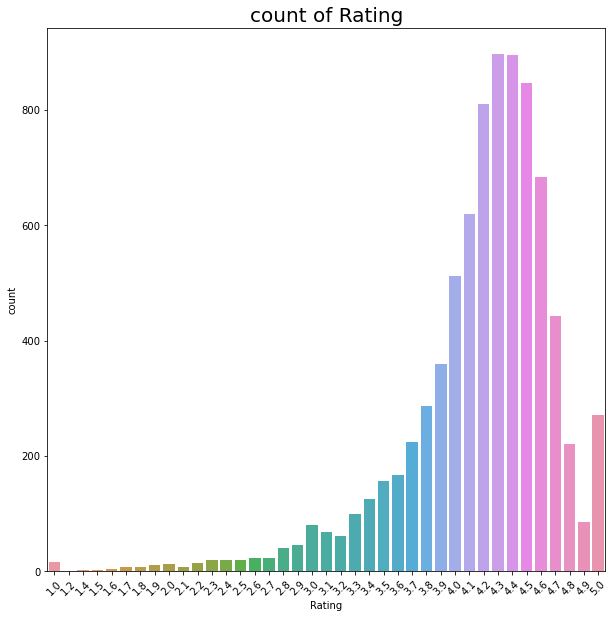

In [254]:
fig, ax1 = plt.subplots(figsize=(10,10))
sns.countplot(data=data, x='Rating', ax=ax1)
ax1.set_xticklabels(['{:.1f}'.format(float(t.get_text())) for t in ax1.get_xticklabels()])
ax1.xaxis.set_tick_params(rotation=45)
plt.title('count of Rating', size=20)

In [255]:
data['Rating'].describe()

count    8190.000000
mean        4.173321
std         0.536691
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

- Rating은 대부분 4.1 ~ 4.6 점에 분포해있다.
- 평균 Rating은 4.19 점이다.

### 2.2.3. Category(카테고리)

Text(0.5, 1.0, 'count of Category')

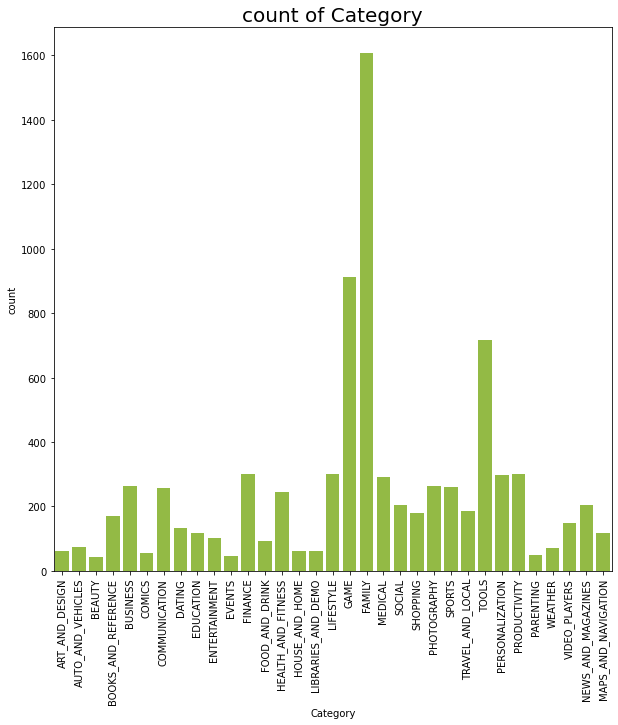

In [256]:
fig, ax = plt.subplots(figsize = (10, 10)) 
sns.countplot(x='Category', data=data, color='yellowgreen')
plt.xticks(rotation=90)
plt.title('count of Category', size=20)

Category 중 가장 수가 많은 3가지는 다음과 같다.
- FAMILY
- GAME
- TOOLS

Text(0.5, 1.0, 'Rating  vs  Category')

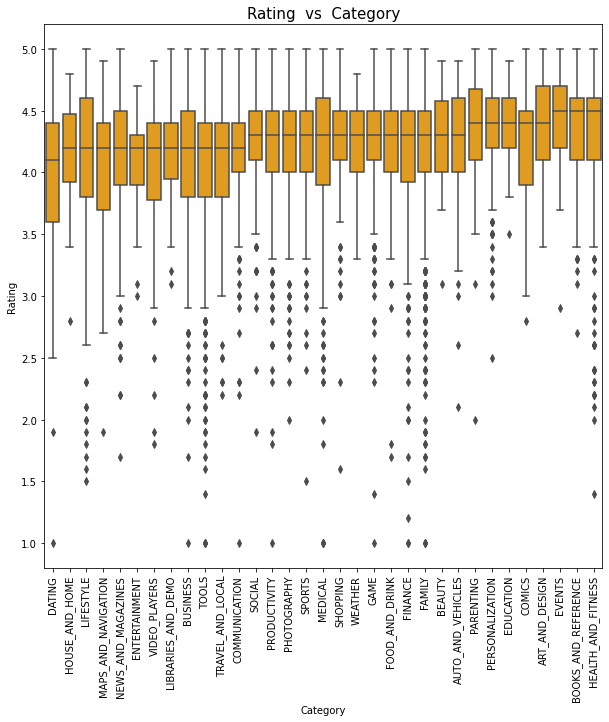

In [257]:
plt.figure(figsize = (10, 10))
result = data.groupby(["Category"])['Rating'].aggregate(np.median).reset_index().sort_values('Rating')
sns.boxplot(x = 'Category', y = 'Rating', data=data, color='orange', order=result['Category'])
plt.xticks(rotation=90)
plt.title('Rating  vs  Category', size=15)

평균 Rating이 높은 Category 3가지는 다음과 같다.
1. HEALTH_AND_FITNESS
2. BOOKS_AND_REFERENCE
3. EVENTS

<br>

평균 Rating이 낮은 3가지는 다음과 같다.
1. DATING
2. HOUSE_AND_HOME
3. LIFESTYLE

### 2.2.4. Reviews(리뷰)를 int형으로 변환

In [258]:
# Reviews 는 1개의 데이터 때문에 object형으로 분류됐지만,
# 결측치로 제거하는 과정에서 없어졌기에 int형으로 변경할 수 있다.
data['Reviews'] = data['Reviews'].astype(int)

In [259]:
data['Reviews'].sort_values()

8379           1
9218           1
6490           1
8497           1
1038           1
          ...   
1670    44891723
335     56642847
2545    66577313
336     69119316
2544    78158306
Name: Reviews, Length: 8190, dtype: int32

Text(0.5, 1.0, 'Reviews  vs  Rating')

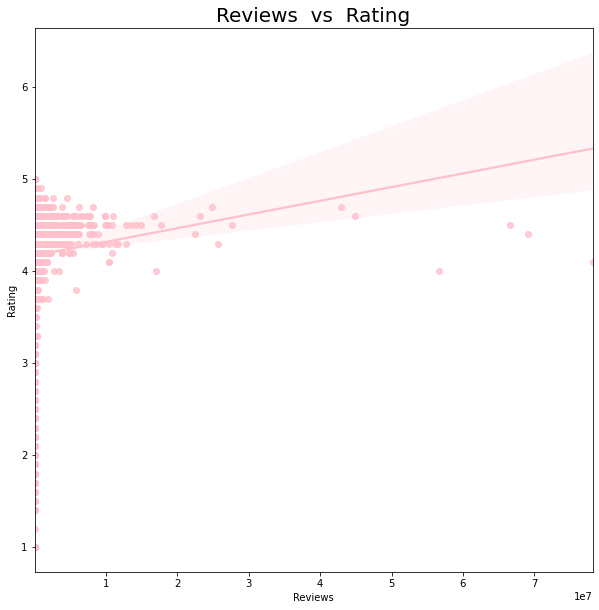

In [260]:
plt.figure(figsize = (10,10))
sns.regplot(x="Reviews", y="Rating", data=data, color='pink')
plt.title('Reviews  vs  Rating', size=20)

KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

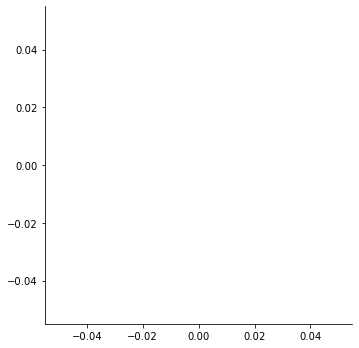

In [362]:
plt.figure(figsize = (10,10))
sns.relplot(x="Reviews", y='Rating', data=data, color='pink', kind="line")
plt.xticks(rotation=30)
plt.title('Reviews  vs  Rating', size=20)

Reviews 는 Rating과 양의 상관관계를 가진다. <br>
그렇지만 리뷰가 아주 많다고 해서 점수가 더 높은 것은 아니다.

### 2.2.5. Size(앱 용량)를 int형으로 변환

In [261]:
# data['Size']의 값들 확인
data['Size'].tail(10)

10828                   13M
10829                  7.4M
10830                  2.3M
10832                  582k
10833                  619k
10834                  2.6M
10836                   53M
10837                  3.6M
10839    Varies with device
10840                   19M
Name: Size, dtype: object

In [262]:
# k와 M을 각각 000과 000000으로 바꿔주되, '.'을 없애준다.
def change(x):
    if 'M' in x:
        if '.' in x:
            x = x.replace('.','')
            x = x.replace('M','00000')
            return x
        else:
            x = x.replace('M','000000')
            return x
    elif 'k' in x:
        if '.' in x:
            x = x.replace('.','')
            x = x.replace('k','00')
            return x
        else:
            x = x.replace('k','000')
            return x
    else:
        return x

data['Size'] = data['Size'].apply(change)

In [263]:
data['Size'].tail(10)

10828              13000000
10829               7400000
10830               2300000
10832                582000
10833                619000
10834               2600000
10836              53000000
10837               3600000
10839    Varies with device
10840              19000000
Name: Size, dtype: object

In [264]:
# 'Varies with device'라는 값을 임의로 '0'으로 바꿔준다.
data['Size'] = data['Size'].replace('Varies with device', '0')

In [265]:
data['Size'].tail(10)

10828    13000000
10829     7400000
10830     2300000
10832      582000
10833      619000
10834     2600000
10836    53000000
10837     3600000
10839           0
10840    19000000
Name: Size, dtype: object

In [266]:
# 전체값들을 int형으로 바꿔준다.
data['Size'] = data['Size'].astype(int)

In [267]:
# 임의로 바꾼 0을 NaN 값으로 바꾼다.
data['Size'] = data['Size'].replace(0, np.nan)

In [268]:
# 변환한 NaN을 각 앱의 카테고리별 평균 값으로 대체한다.
data['Size'] = data['Size'].fillna(data.groupby('Category')['Size'].transform('mean'))

Text(0.5, 1.0, 'Size  vs  Rating')

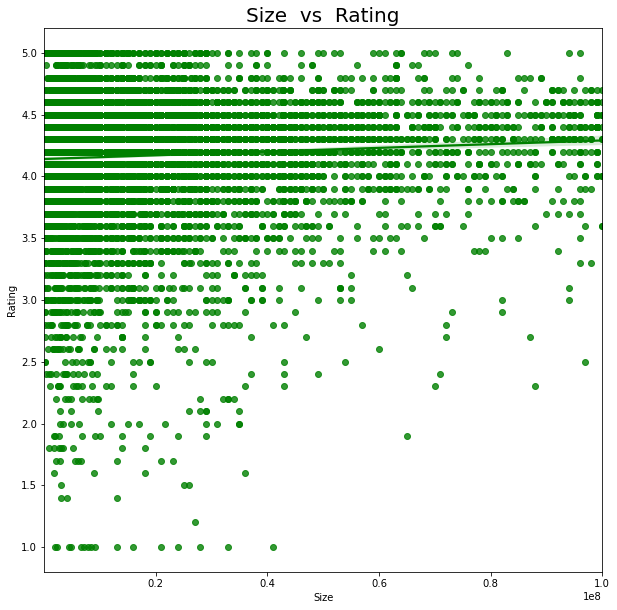

In [269]:
plt.figure(figsize = (10,10))
sns.regplot(x="Size", y="Rating", data=data, color='green')
plt.title('Size  vs  Rating', size=20)

- Size는 Rating과 양의 상관관계를 가진다.
- 즉, 용량이 클수록 점수가 높다.

### 2.2.6. Installs(다운로드 횟수)를 int 형으로 변환

In [270]:
data['Installs'].unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000,000,000+', '1,000+', '500,000,000+', '100+', '500+', '10+',
       '5+', '50+', '1+'], dtype=object)

In [271]:
data['Installs'] = data['Installs'].str.replace('+', '')
data['Installs'] = data['Installs'].str.replace(',', '')

In [272]:
data['Installs'] = data['Installs'].astype(int)

In [273]:
data['Installs'].unique()

array([     10000,     500000,    5000000,   50000000,     100000,
            50000,    1000000,   10000000,       5000,  100000000,
       1000000000,       1000,  500000000,        100,        500,
               10,          5,         50,          1])

Text(0.5, 1.0, 'Install  vs  Rating')

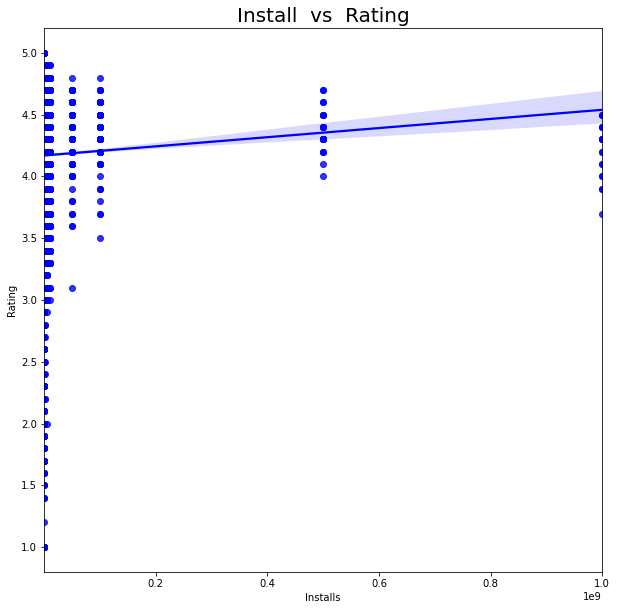

In [274]:
plt.figure(figsize = (10,10))
sns.regplot(x="Installs", y="Rating", data=data, color='blue')
plt.title('Install  vs  Rating', size=20)

Install은 Rating과 양의 상관관계를 가진다.

Text(0.5, 1.0, 'datail_Install  vs  Rating')

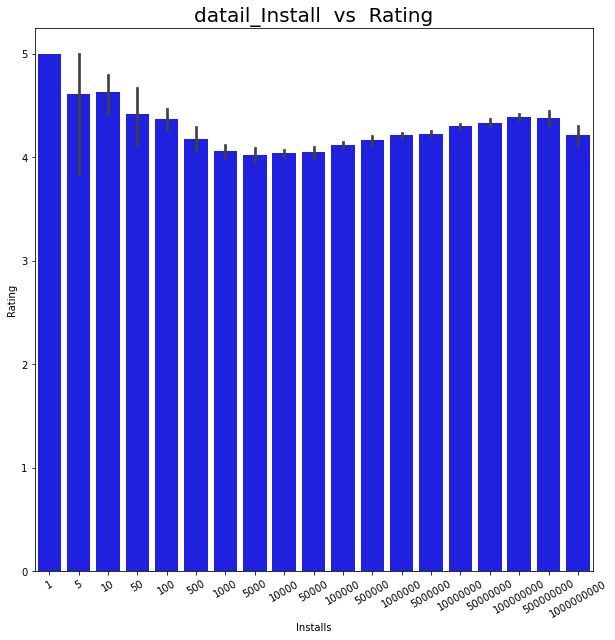

In [275]:
plt.figure(figsize = (10,10))
sns.barplot(x="Installs", y='Rating', data=data, color='blue')
plt.xticks(rotation=30)
plt.title('datail_Install  vs  Rating', size=20)

- install 횟수가 50 이하인 것은 표본이 너무 적기에 반영하지 않는다.
- 100 ~ 5000회까지 점수가 점전 낮아지지만, 5000회 이후부터는 점수가 증가한다.
- install 횟수가 많을 수록 점수가 높을 것으로 예상했지만 5억을 넘어가면 오히려 낮아진다.

### 2.2.7. Type(유/무료)를 int 형으로 변환

In [276]:
data['Type'].unique()

array(['Free', 'Paid'], dtype=object)

Text(0.5, 1.0, 'Free  vs  Paid  (count)')

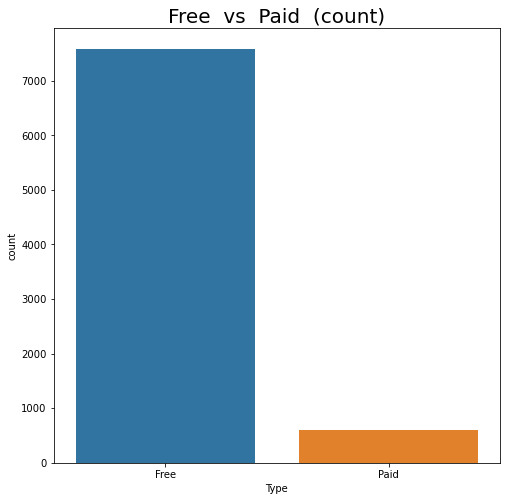

In [277]:
fig, ax = plt.subplots(figsize = (8, 8)) 
sns.countplot(x='Type', data=data)
plt.title('Free  vs  Paid  (count)', size=20)

Text(0.5, 1.0, 'Free  vs  Paid  (Rating)')

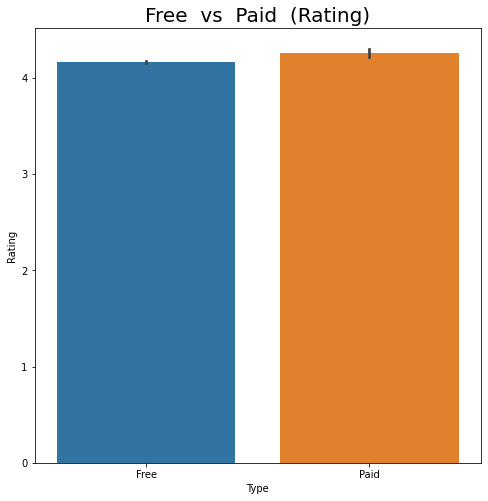

In [278]:
# Free 보다는 Paid가 약간 더 Rating가 높지만 큰 차이는 아니다.
plt.figure(figsize = (8,8))
sns.barplot(x="Type", y="Rating", data=data)
plt.title('Free  vs  Paid  (Rating)', size=20)

Paid(유료)가 약간 더 점수가 높지만, 거의 비슷하다.

### 2.2.8. Price(가격)에서 $빼고 float 형으로 변환, 이상치 제거

In [279]:
data['Price'].value_counts().head()

0        7588
$2.99     109
$0.99     103
$4.99      68
$1.99      59
Name: Price, dtype: int64

In [280]:
data['Price'] = data['Price'].str.replace('$', '')

In [281]:
data['Price'].value_counts().head()

0       7588
2.99     109
0.99     103
4.99      68
1.99      59
Name: Price, dtype: int64

In [282]:
data['Price'] = data['Price'].astype(float)

In [283]:
#가격이 무려 400달러나 되는 앱이 있다.
data['Price'].describe()

count    8190.000000
mean        1.038342
std        16.864040
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       400.000000
Name: Price, dtype: float64

Text(0.5, 1.0, 'distribution of Price')

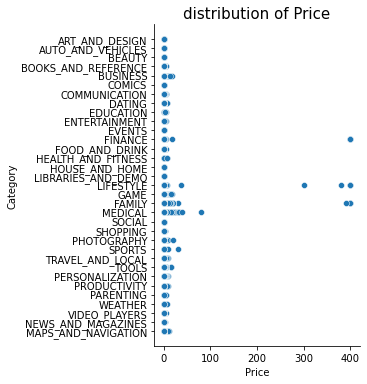

In [284]:
sns.relplot(x="Price", y="Category", data=data)
plt.title('distribution of Price', size=15)

In [286]:
data[data['Price'] > 299]

# 확인해보니  I'm rich 라는 자신의 부유함을 과시하는 앱으로, 아무런 기능도 없는 앱이다.
# 이 앱들은 이번 프로젝트의 방향과는 맞지 않으니 제거해주도록 한다.

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
4197,most expensive app (H),FAMILY,4.3,6,1500000.0,100,Paid,399.99,Everyone,Entertainment,"July 16, 2018",1.0,7.0 and up
4362,💎 I'm rich,LIFESTYLE,3.8,718,26000000.0,10000,Paid,399.99,Everyone,Lifestyle,"March 11, 2018",1.0.0,4.4 and up
4367,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7300000.0,10000,Paid,400.00,Everyone,Lifestyle,"May 3, 2018",1.0.1,4.1 and up
5351,I am rich,LIFESTYLE,3.8,3547,1800000.0,100000,Paid,399.99,Everyone,Lifestyle,"January 12, 2018",2.0,4.0.3 and up
5354,I am Rich Plus,FAMILY,4.0,856,8700000.0,10000,Paid,399.99,Everyone,Entertainment,"May 19, 2018",3.0,4.4 and up
5355,I am rich VIP,LIFESTYLE,3.8,411,2600000.0,10000,Paid,299.99,Everyone,Lifestyle,"July 21, 2018",1.1.1,4.3 and up
5356,I Am Rich Premium,FINANCE,4.1,1867,4700000.0,50000,Paid,399.99,Everyone,Finance,"November 12, 2017",1.6,4.0 and up
5357,I am extremely Rich,LIFESTYLE,2.9,41,2900000.0,1000,Paid,379.99,Everyone,Lifestyle,"July 1, 2018",1.0,4.0 and up
5358,I am Rich!,FINANCE,3.8,93,22000000.0,1000,Paid,399.99,Everyone,Finance,"December 11, 2017",1.0,4.1 and up
5359,I am rich(premium),FINANCE,3.5,472,965000.0,5000,Paid,399.99,Everyone,Finance,"May 1, 2017",3.4,4.4 and up


In [287]:
rich = data[data['Price'] > 299].index
data.drop(rich, inplace=True)

Text(0.5, 1.0, 'New Price')

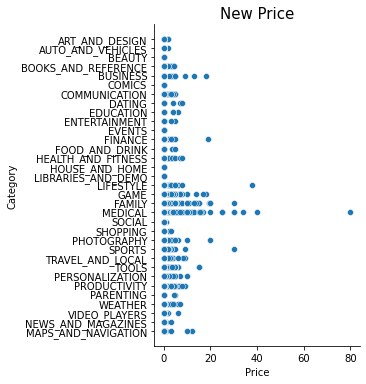

In [288]:
sns.relplot(x="Price", y="Category", data=data)
plt.title('New Price', size=15)

In [289]:
def separate_price(x) :
    if x == 0:
        return '0'
    elif 0<x and x<=1:
        return '0~1'
    elif 1<x and x<=3:
        return '1~3'
    elif 3<x and x<=5:
        return '3~5'
    elif 5<x and x<=10:
        return '5~10'
    elif 10<x and x<=20:
        return '10~20'
    else:
        return '20~'
    
data['separate_Price'] = data['Price'].apply(separate_price)

Text(0.5, 1.0, 'separate_Price  vs  Rating')

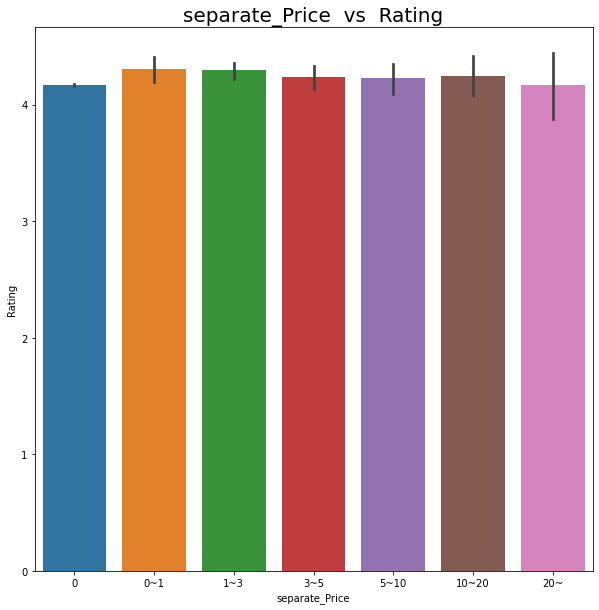

In [290]:
plt.figure(figsize = (10,10))
sns.barplot(x="separate_Price", y="Rating", order=["0", "0~1", "1~3", "3~5", "5~10", "10~20", "20~"], data=data)
plt.title('separate_Price  vs  Rating', size=20)

가격이 무료 ~ 20달러인 App 의 점수는 비슷하지만, 유료 App은 20달러가 넘어가면 점수가 다소 낮아진다. <br>
유료 중에서는 3달러 이하가 가격이 적절해보인다.

In [291]:
# 데이터(행)의 개수는 최종적으로 8175개가 됐다.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8175 entries, 0 to 10840
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             8175 non-null   object 
 1   Category        8175 non-null   object 
 2   Rating          8175 non-null   float64
 3   Reviews         8175 non-null   int32  
 4   Size            8175 non-null   float64
 5   Installs        8175 non-null   int32  
 6   Type            8175 non-null   object 
 7   Price           8175 non-null   float64
 8   Content Rating  8175 non-null   object 
 9   Genres          8175 non-null   object 
 10  Last Updated    8175 non-null   object 
 11  Current Ver     8175 non-null   object 
 12  Android Ver     8175 non-null   object 
 13  separate_Price  8175 non-null   object 
dtypes: float64(3), int32(2), object(9)
memory usage: 1.2+ MB


### 2.2.9. Content Rating(이용등급)

In [292]:
data['Content Rating'].unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+',
       'Adults only 18+', 'Unrated'], dtype=object)

In [293]:
data['Content Rating'].value_counts()

Everyone           6598
Teen                911
Mature 17+          357
Everyone 10+        305
Adults only 18+       3
Unrated               1
Name: Content Rating, dtype: int64

Text(0.5, 1.0, 'count of Content rating')

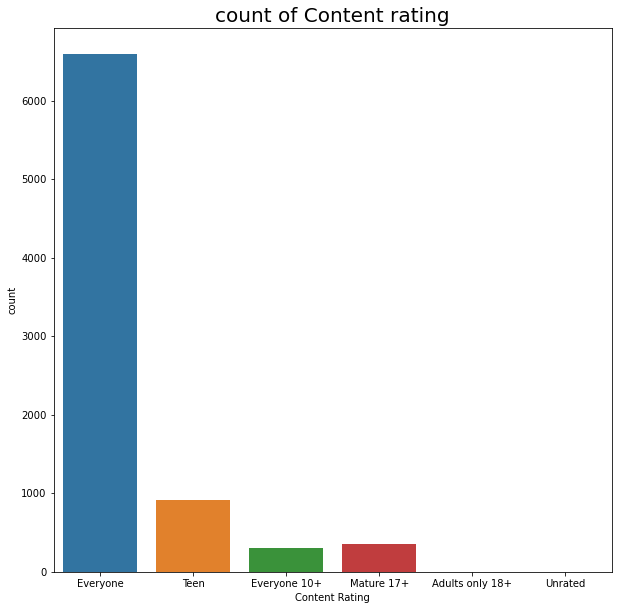

In [294]:
fig, ax = plt.subplots(figsize = (10, 10)) 
sns.countplot(x='Content Rating', data=data)
plt.title('count of Content rating', size=20)

콘텐츠 등급은 Everyone이 압도적으로 많다.

In [295]:
data[data['Content Rating'] =='Unrated']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,separate_Price
8266,DC Universe Online Map,TOOLS,4.1,1186,6400000.0,50000,Free,0.0,Unrated,Tools,"February 27, 2012",1.3,2.3.3 and up,0


Text(0.5, 1.0, 'each Content rating  vs  Rating')

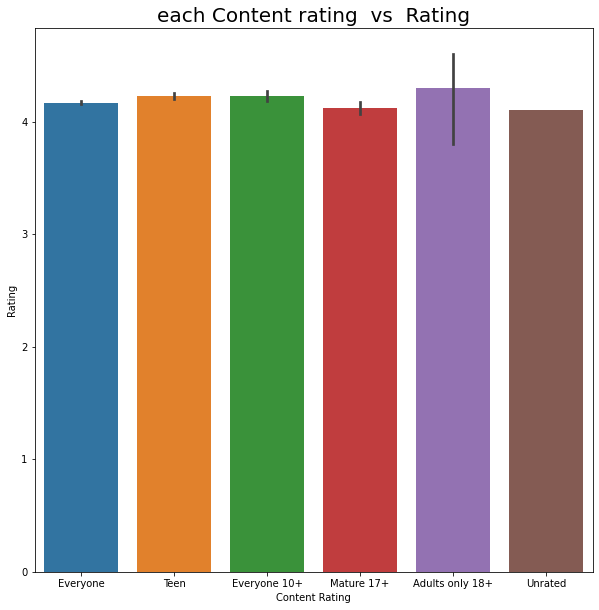

In [296]:
fig, ax = plt.subplots(figsize = (10, 10)) 
sns.barplot(x='Content Rating', y='Rating', data=data)
plt.title('each Content rating  vs  Rating', size=20)

- Adults only 18+과 Unrated는 표본이 적어서 그대로 반영하기는 어렵다.
- 콘텐츠 등급별 점수차이는 별로 없지만 Teen, Everyone 10+, Everyone 가 점수가 높은 편이다.

### 2.2.10. Genres(세부/중복 카테고리) 간략화

In [297]:
# Genres는 Category의 세부분류이거나 중복 카테고리를 표시한 것이지만, 대부분이 Category와 겹친다.
data['Genres']

0                     Art & Design
1        Art & Design;Pretend Play
2                     Art & Design
3                     Art & Design
4          Art & Design;Creativity
                   ...            
10834                    Education
10836                    Education
10837                    Education
10839            Books & Reference
10840                    Lifestyle
Name: Genres, Length: 8175, dtype: object

In [298]:
# 또한 세부분류를 한 것들은 각각의 수가 너무 적어서 의미있는 데이터라고 보기 어렵다.
data.Genres.value_counts().tail(15)

Strategy;Education                    1
Communication;Creativity              1
Board;Pretend Play                    1
Art & Design;Pretend Play             1
Comics;Creativity                     1
Music & Audio;Music & Video           1
Entertainment;Education               1
Adventure;Education                   1
Casual;Music & Video                  1
Lifestyle;Education                   1
Puzzle;Education                      1
Travel & Local;Action & Adventure     1
Video Players & Editors;Creativity    1
Lifestyle;Pretend Play                1
Arcade;Pretend Play                   1
Name: Genres, dtype: int64

In [299]:
# 따라서 Genres의 값들을 ; 을 기준으로 나눈 뒤 앞의 값들만 사용한다.
data['Genres'] = data['Genres'].str.split(';').str[0]

In [300]:
data['Genres'].unique()

array(['Art & Design', 'Auto & Vehicles', 'Beauty', 'Books & Reference',
       'Business', 'Comics', 'Communication', 'Dating', 'Education',
       'Entertainment', 'Events', 'Finance', 'Food & Drink',
       'Health & Fitness', 'House & Home', 'Libraries & Demo',
       'Lifestyle', 'Adventure', 'Arcade', 'Casual', 'Card', 'Action',
       'Strategy', 'Puzzle', 'Sports', 'Music', 'Word', 'Racing',
       'Simulation', 'Board', 'Trivia', 'Role Playing', 'Educational',
       'Music & Audio', 'Video Players & Editors', 'Medical', 'Social',
       'Shopping', 'Photography', 'Travel & Local', 'Tools',
       'Personalization', 'Productivity', 'Parenting', 'Weather',
       'News & Magazines', 'Maps & Navigation', 'Casino'], dtype=object)

In [301]:
# Music & Audio 은 Music에 포함시키기로 한다.
data.Genres.value_counts().tail(10)

Comics           54
Parenting        50
Card             46
Events           45
Beauty           42
Casino           37
Trivia           28
Word             22
Music            21
Music & Audio     1
Name: Genres, dtype: int64

In [302]:
data['Genres'] = data['Genres'].str.replace('Music & Audio', 'Music')

In [303]:
data.Genres.value_counts().tail(10)

Board        57
Comics       54
Parenting    50
Card         46
Events       45
Beauty       42
Casino       37
Trivia       28
Word         22
Music        22
Name: Genres, dtype: int64

Text(0.5, 1.0, 'Genres  vs  Rating')

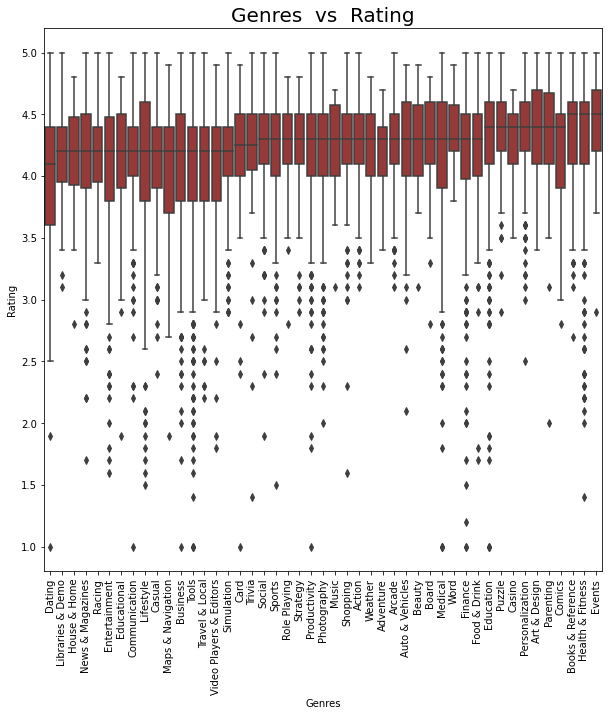

In [304]:
plt.figure(figsize = (10,10))
result2 = data.groupby(["Genres"])['Rating'].aggregate(np.median).reset_index().sort_values('Rating')
sns.boxplot(x="Genres", y="Rating", data=data, color='brown', order=result2['Genres'])
plt.xticks(rotation=90)
plt.title('Genres  vs  Rating', size=20)

평균 Rating이 높은 Genres 3가지는 다음과 같다.
- EVENTS
- HEALTH_AND_FITNESS
- BOOKS_AND_REFERENCE

TOP3는 Category와 같으나, Grens에서는 EVENTS가 3위에서 1위로 올라왔다.


<br>

평균 Rating이 낮은 3가지는 다음과 같다.
1. DATING
2. LIBRARIES & DEMO
3. HOUSE_AND_HOME

DATING은 Category에서와 마찬가지로 가장 점수가 낮다.

In [305]:
####################################################################
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8175 entries, 0 to 10840
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             8175 non-null   object 
 1   Category        8175 non-null   object 
 2   Rating          8175 non-null   float64
 3   Reviews         8175 non-null   int32  
 4   Size            8175 non-null   float64
 5   Installs        8175 non-null   int32  
 6   Type            8175 non-null   object 
 7   Price           8175 non-null   float64
 8   Content Rating  8175 non-null   object 
 9   Genres          8175 non-null   object 
 10  Last Updated    8175 non-null   object 
 11  Current Ver     8175 non-null   object 
 12  Android Ver     8175 non-null   object 
 13  separate_Price  8175 non-null   object 
dtypes: float64(3), int32(2), object(9)
memory usage: 1.2+ MB


### 2.2.11. Last Updated를 int 형으로 변환
Last Updated는 숫자와 문자가 섞여있어서 바로 datetime 형식으로 바꾸는데 어려움이 있다.<br>
따라서 Last Updated 상의 가장 최근 날짜를 현재날짜라 가정하고, 각 데이터의 Last Updated 날짜에서 현재날짜를 뺌으로서 마지막 업데이트를 한 지 몇 일이 지났는지 계산하는 방식을 이용한다.

In [306]:
data['Last Updated']

0         January 7, 2018
1        January 15, 2018
2          August 1, 2018
3            June 8, 2018
4           June 20, 2018
               ...       
10834       June 18, 2017
10836       July 25, 2017
10837        July 6, 2018
10839    January 19, 2015
10840       July 25, 2018
Name: Last Updated, Length: 8175, dtype: object

In [307]:
data['date'] = pd.to_datetime(data['Last Updated'])
data['date'].describe()

count                    8175
unique                   1299
top       2018-08-03 00:00:00
freq                      245
first     2010-05-21 00:00:00
last      2018-08-08 00:00:00
Name: date, dtype: object

In [308]:
data['date'].max()
# 2018-08-08을 현재날짜라고 가정한다.

Timestamp('2018-08-08 00:00:00')

In [309]:
# lastupdate 컬럼을 만들어 계산한 값을 넣는다.
data['lastupdate'] = (data['date'] -  data['date'].max()).dt.days
data['lastupdate'].head()

0   -213
1   -205
2     -7
3    -61
4    -49
Name: lastupdate, dtype: int64

In [310]:
# date는 지워준다.
data = data.drop(labels = ['date'], axis = 1)

# Last Updated도 지운다.
data = data.drop(labels = ['Last Updated'], axis = 1)

Text(0.5, 1.0, 'lastupdate  vs  Rating')

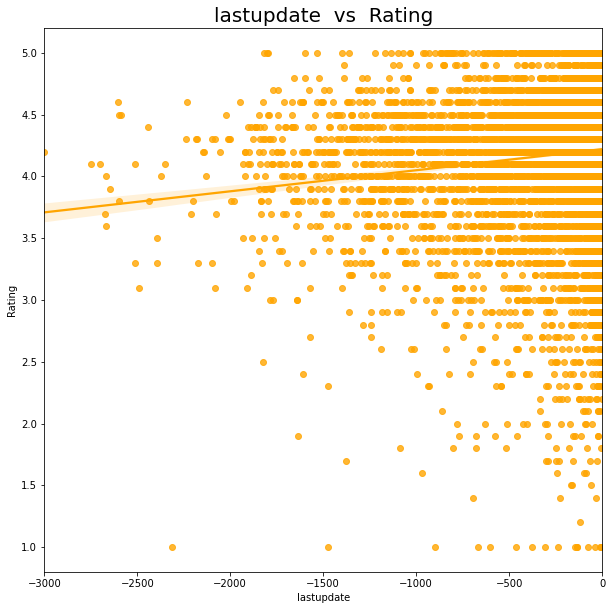

In [311]:
plt.figure(figsize = (10,10))
sns.regplot(x="lastupdate", y="Rating", data=data, color='orange')
plt.title('lastupdate  vs  Rating', size=20)

- lastupdate와 Rating은 양의 상관관게를 갖는다.
- 즉, 최근에 업데이트 했을 수록 Rating이 높다.

### 2.2.12. App, Current Ver, Android Ver 제거

In [312]:
# App은 고유한 이름이기에 데이터로 사용하기에 어려움이 잇음으로 제거
data = data.drop(labels = ['App'], axis = 1)

In [313]:
# Current Ver, Android Ver는 앱마다 버전의 기준이 다르며,
# 'Varies with device' 값을 다른 것으로 대체하기 어렵기 때문에
# 해석에 어려움이 있을 것으로 판단 되어 제거.
data = data.drop(labels = ['Current Ver', 'Android Ver'], axis = 1)

## 2.3. 원핫 인코딩

In [314]:
data.dtypes

Category           object
Rating            float64
Reviews             int32
Size              float64
Installs            int32
Type               object
Price             float64
Content Rating     object
Genres             object
separate_Price     object
lastupdate          int64
dtype: object

In [315]:
# Price_detail은 확인했으니 지워준다.
data = data.drop(labels = ['separate_Price'], axis = 1)

In [316]:
data = pd.get_dummies(data, columns = ['Category', 'Type', 'Content Rating', 'Genres'])
data.head()

,Rating,Reviews,Size,Installs,Price,lastupdate,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,...,Genres_Simulation,Genres_Social,Genres_Sports,Genres_Strategy,Genres_Tools,Genres_Travel & Local,Genres_Trivia,Genres_Video Players & Editors,Genres_Weather,Genres_Word
0,4.1,159,19000000.0,10000,0.0,-213,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.9,967,14000000.0,500000,0.0,-205,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.7,87510,8700000.0,5000000,0.0,-7,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.5,215644,25000000.0,50000000,0.0,-61,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.3,967,2800000.0,100000,0.0,-49,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2.4. train 과 test 데이터로 나누기

In [317]:
data.info()
# 데이터는 총 8175개

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8175 entries, 0 to 10840
Data columns (total 94 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Rating                          8175 non-null   float64
 1   Reviews                         8175 non-null   int32  
 2   Size                            8175 non-null   float64
 3   Installs                        8175 non-null   int32  
 4   Price                           8175 non-null   float64
 5   lastupdate                      8175 non-null   int64  
 6   Category_ART_AND_DESIGN         8175 non-null   uint8  
 7   Category_AUTO_AND_VEHICLES      8175 non-null   uint8  
 8   Category_BEAUTY                 8175 non-null   uint8  
 9   Category_BOOKS_AND_REFERENCE    8175 non-null   uint8  
 10  Category_BUSINESS               8175 non-null   uint8  
 11  Category_COMICS                 8175 non-null   uint8  
 12  Category_COMMUNICATION          8

In [318]:
# 8175개의 데이터 중 8:2 비율로 train, test 데이터를 지정한다.

from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=7)

In [319]:
train.columns

Index(['Rating', 'Reviews', 'Size', 'Installs', 'Price', 'lastupdate',
       'Category_ART_AND_DESIGN', 'Category_AUTO_AND_VEHICLES',
       'Category_BEAUTY', 'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS',
       'Category_COMICS', 'Category_COMMUNICATION', 'Category_DATING',
       'Category_EDUCATION', 'Category_ENTERTAINMENT', 'Category_EVENTS',
       'Category_FAMILY', 'Category_FINANCE', 'Category_FOOD_AND_DRINK',
       'Category_GAME', 'Category_HEALTH_AND_FITNESS',
       'Category_HOUSE_AND_HOME', 'Category_LIBRARIES_AND_DEMO',
       'Category_LIFESTYLE', 'Category_MAPS_AND_NAVIGATION',
       'Category_MEDICAL', 'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER', 'Type_Free', 'Type_Paid',
       'Content Rating_A

In [320]:
# Rating을 제외한 나머지를 input_var라는 변수에 넣어서 사용

input_var = ['Reviews', 'Size', 'Installs', 'Price', 'lastupdate',
       'Category_ART_AND_DESIGN', 'Category_AUTO_AND_VEHICLES',
       'Category_BEAUTY', 'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS',
       'Category_COMICS', 'Category_COMMUNICATION', 'Category_DATING',
       'Category_EDUCATION', 'Category_ENTERTAINMENT', 'Category_EVENTS',
       'Category_FAMILY', 'Category_FINANCE', 'Category_FOOD_AND_DRINK',
       'Category_GAME', 'Category_HEALTH_AND_FITNESS',
       'Category_HOUSE_AND_HOME', 'Category_LIBRARIES_AND_DEMO',
       'Category_LIFESTYLE', 'Category_MAPS_AND_NAVIGATION',
       'Category_MEDICAL', 'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER', 'Type_Free', 'Type_Paid',
       'Content Rating_Adults only 18+', 'Content Rating_Everyone',
       'Content Rating_Everyone 10+', 'Content Rating_Mature 17+',
       'Content Rating_Teen', 'Content Rating_Unrated', 'Genres_Action',
       'Genres_Adventure', 'Genres_Arcade', 'Genres_Art & Design',
       'Genres_Auto & Vehicles', 'Genres_Beauty', 'Genres_Board',
       'Genres_Books & Reference', 'Genres_Business', 'Genres_Card',
       'Genres_Casino', 'Genres_Casual', 'Genres_Comics',
       'Genres_Communication', 'Genres_Dating', 'Genres_Education',
       'Genres_Educational', 'Genres_Entertainment', 'Genres_Events',
       'Genres_Finance', 'Genres_Food & Drink', 'Genres_Health & Fitness',
       'Genres_House & Home', 'Genres_Libraries & Demo', 'Genres_Lifestyle',
       'Genres_Maps & Navigation', 'Genres_Medical', 'Genres_Music',
       'Genres_News & Magazines', 'Genres_Parenting', 'Genres_Personalization',
       'Genres_Photography', 'Genres_Productivity', 'Genres_Puzzle',
       'Genres_Racing', 'Genres_Role Playing', 'Genres_Shopping',
       'Genres_Simulation', 'Genres_Social', 'Genres_Sports',
       'Genres_Strategy', 'Genres_Tools', 'Genres_Travel & Local',
       'Genres_Trivia', 'Genres_Video Players & Editors', 'Genres_Weather',
       'Genres_Word']

## 2.5. 모델링

### 2.5.1. 상관계수 확인

만약 인풋변수들 끼리 서로 상관성이 높으면 shap value시 모델을 해석하는 데에 어려움이 있을 수 있다.
때문에 모델링 전에 서로 높은 상관성을 띄는 변수들을 제거해준다.

In [321]:
# corr()로 상관계수 확인
corr = train[input_var].corr()

# 시각화
corr.style.background_gradient(cmap='coolwarm')

# 붉은 색일수록 상관계수가 높다.

1차 확인 결과 Category와 Genres 간의 상관계수가 대부분이 1이거나 1에 가까우므로
<br> Genres관련 변수들을 모두 지워주고 다시 살펴본다.

In [322]:
genres = ['Genres_Action',
       'Genres_Adventure', 'Genres_Arcade', 'Genres_Art & Design',
       'Genres_Auto & Vehicles', 'Genres_Beauty', 'Genres_Board',
       'Genres_Books & Reference', 'Genres_Business', 'Genres_Card',
       'Genres_Casino', 'Genres_Casual', 'Genres_Comics',
       'Genres_Communication', 'Genres_Dating', 'Genres_Education',
       'Genres_Educational', 'Genres_Entertainment', 'Genres_Events',
       'Genres_Finance', 'Genres_Food & Drink', 'Genres_Health & Fitness',
       'Genres_House & Home', 'Genres_Libraries & Demo', 'Genres_Lifestyle',
       'Genres_Maps & Navigation', 'Genres_Medical', 'Genres_Music',
       'Genres_News & Magazines', 'Genres_Parenting', 'Genres_Personalization',
       'Genres_Photography', 'Genres_Productivity', 'Genres_Puzzle',
       'Genres_Racing', 'Genres_Role Playing', 'Genres_Shopping',
       'Genres_Simulation', 'Genres_Social', 'Genres_Sports',
       'Genres_Strategy', 'Genres_Tools', 'Genres_Travel & Local',
       'Genres_Trivia', 'Genres_Video Players & Editors', 'Genres_Weather',
       'Genres_Word']

train = train.drop(labels = genres, axis = 1)
test = test.drop(labels = genres, axis = 1)

In [323]:
train.columns

Index(['Rating', 'Reviews', 'Size', 'Installs', 'Price', 'lastupdate',
       'Category_ART_AND_DESIGN', 'Category_AUTO_AND_VEHICLES',
       'Category_BEAUTY', 'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS',
       'Category_COMICS', 'Category_COMMUNICATION', 'Category_DATING',
       'Category_EDUCATION', 'Category_ENTERTAINMENT', 'Category_EVENTS',
       'Category_FAMILY', 'Category_FINANCE', 'Category_FOOD_AND_DRINK',
       'Category_GAME', 'Category_HEALTH_AND_FITNESS',
       'Category_HOUSE_AND_HOME', 'Category_LIBRARIES_AND_DEMO',
       'Category_LIFESTYLE', 'Category_MAPS_AND_NAVIGATION',
       'Category_MEDICAL', 'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER', 'Type_Free', 'Type_Paid',
       'Content Rating_A

In [324]:
input_var = ['Reviews', 'Size', 'Installs', 'Price', 'lastupdate',
       'Category_ART_AND_DESIGN', 'Category_AUTO_AND_VEHICLES',
       'Category_BEAUTY', 'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS',
       'Category_COMICS', 'Category_COMMUNICATION', 'Category_DATING',
       'Category_EDUCATION', 'Category_ENTERTAINMENT', 'Category_EVENTS',
       'Category_FAMILY', 'Category_FINANCE', 'Category_FOOD_AND_DRINK',
       'Category_GAME', 'Category_HEALTH_AND_FITNESS',
       'Category_HOUSE_AND_HOME', 'Category_LIBRARIES_AND_DEMO',
       'Category_LIFESTYLE', 'Category_MAPS_AND_NAVIGATION',
       'Category_MEDICAL', 'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER', 'Type_Free', 'Type_Paid',
       'Content Rating_Adults only 18+', 'Content Rating_Everyone',
       'Content Rating_Everyone 10+', 'Content Rating_Mature 17+',
       'Content Rating_Teen', 'Content Rating_Unrated']

In [325]:
# corr()로 상관계수 확인
corr = train[input_var].corr()

# 시각화
corr.style.background_gradient(cmap='coolwarm')

,Reviews,Size,Installs,Price,lastupdate,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Type_Free,Type_Paid,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
Reviews,1.000000,0.066678,0.634373,-0.022090,0.068934,-0.008991,-0.010669,-0.008977,-0.013034,-0.020111,-0.008260,0.086493,-0.014054,-0.011976,0.001872,-0.009233,-0.040159,-0.020928,-0.009966,0.063553,-0.014380,-0.009188,-0.010506,-0.019726,-0.005188,-0.023424,-0.010490,-0.008983,-0.007167,0.012105,-0.008285,-0.000766,0.074332,-0.010379,0.011115,-0.008625,0.015515,-0.004625,0.033967,-0.033967,-0.001412,-0.061759,0.043516,-0.000590,0.051415,nan
Size,0.066678,1.000000,0.031306,0.003522,0.206197,-0.028198,0.003132,-0.023763,-0.046978,-0.064285,-0.028201,-0.084603,-0.016979,-0.011200,0.002119,-0.025371,0.185494,-0.033019,0.006646,0.354833,0.011951,-0.018521,-0.041637,-0.059757,-0.016115,-0.023348,-0.066026,0.000972,-0.093244,-0.049873,-0.082748,-0.037137,-0.036205,0.039070,-0.192253,0.017791,-0.036029,-0.037171,0.007358,-0.007358,-0.009579,-0.227134,0.147544,0.047163,0.165009,nan
Installs,0.634373,0.031306,1.000000,-0.028438,0.083754,-0.009448,-0.013215,-0.010938,0.000760,-0.023204,-0.011729,0.121294,-0.017848,-0.015400,0.003524,-0.011477,-0.054520,-0.026114,-0.012624,0.028065,-0.012607,-0.011040,-0.012904,-0.024419,-0.009676,-0.029665,0.011039,-0.011525,-0.013668,0.027508,0.034926,-0.003097,0.049766,-0.015633,0.015000,0.005241,0.046358,-0.007061,0.043807,-0.043807,-0.001856,-0.043831,0.016072,-0.007884,0.050306,nan
Price,-0.022090,0.003522,-0.028438,1.000000,-0.104057,-0.012578,-0.014764,-0.013448,-0.012337,-0.009774,-0.014705,-0.015864,-0.009172,-0.012197,-0.015578,-0.013448,0.031708,-0.017720,-0.011116,0.004189,-0.021094,-0.015213,-0.016024,-0.002918,-0.003631,0.174881,-0.026596,-0.003568,0.005378,-0.011716,-0.004990,-0.024950,-0.028269,0.006035,-0.007315,-0.007661,-0.018890,0.011595,-0.648096,0.648096,-0.002235,0.002561,0.013296,-0.001857,-0.009971,nan
lastupdate,0.068934,0.206197,0.083754,-0.104057,1.000000,0.031684,0.041168,0.028898,-0.029621,0.002659,0.033943,-0.008280,0.058349,0.002433,0.045231,0.027955,-0.061710,0.055597,0.045917,-0.046563,0.049994,0.000555,-0.039510,-0.008082,0.037346,-0.022227,0.040889,0.031495,-0.085388,0.010602,-0.013773,0.060557,0.035953,0.032912,-0.065137,0.039014,-0.006264,0.007821,0.188463,-0.188463,0.007301,-0.055198,-0.004524,0.052933,0.037424,nan
Category_ART_AND_DESIGN,-0.008991,-0.028198,-0.009448,-0.012578,0.031684,1.000000,-0.007492,-0.006053,-0.011988,-0.014708,-0.006618,-0.014671,-0.010138,-0.009982,-0.008821,-0.006053,-0.040034,-0.016117,-0.008277,-0.029214,-0.014186,-0.006847,-0.007212,-0.015427,-0.009982,-0.015497,-0.012966,-0.006382,-0.015671,-0.015035,-0.015879,-0.012032,-0.013210,-0.014891,-0.025355,-0.012507,-0.011449,-0.007423,0.015378,-0.015378,-0.001006,0.020680,-0.006246,-0.017302,-0.010912,nan
Category_AUTO_AND_VEHICLES,-0.010669,0.003132,-0.013215,-0.014764,0.041168,-0.007492,1.000000,-0.006852,-0.013571,-0.016650,-0.007492,-0.016608,-0.011476,-0.011300,-0.009986,-0.006852,-0.045319,-0.018245,-0.009369,-0.033070,-0.016059,-0.007751,-0.008164,-0.017463,-0.011300,-0.017543,-0.014677,-0.007224,-0.017740,-0.017020,-0.017975,-0.013621,-0.014954,-0.016856,-0.028702,-0.014158,-0.012960,-0.008403,0.0

높은 상관성을 띄는 변수는 다음과 같다.

- Installs, Reviews
- Price, Category_MEDICAL
- Price, Type_Paid
- Category_GAME, Size
- Category_DATING, Content Rating_Mature 17+
- Content Rating_Teen, Category_ENTERTAINMENT

각 쌍 중 하나의 변수만 제거해야한다. 그 기준은 타겟값과의 상관계수.<br>
상관계수의 절대값이 더 작은 것을 제거한다.<br>
타겟값 : Raiting

In [326]:
train['Installs'].corr(train['Rating'])

0.03905807986834021

In [327]:
train['Reviews'].corr(train['Rating'])

0.052661347048505794

In [328]:
# Installs 를 제거
del train['Installs']
del test['Installs']

In [329]:
train['Price'].corr(train['Rating'])

0.016837530305883034

In [330]:
train['Category_MEDICAL'].corr(train['Rating'])

-0.013338185319412865

In [331]:
train['Type_Paid'].corr(train['Rating'])

0.044628843197085794

In [332]:
# Price에 비해 Category_MEDICAL이 타겟값과의 상관은 가장 적으나,
# Price와 Type_Paid를 비교했을 때는 Price를 제거해야 하므로
# Price만 제거하고 Category_MEDICAL은 남겨둔다.
del train['Price']
del test['Price']

In [333]:
train['Category_GAME'].corr(train['Rating'])

0.05431845019711825

In [334]:
train['Size'].corr(train['Rating'])

0.0647938688977828

In [335]:
# Category_GAME 을 제거
del train['Category_GAME']
del test['Category_GAME']

In [336]:
train['Category_DATING'].corr(train['Rating'])

-0.052867342763879534

In [337]:
train['Content Rating_Mature 17+'].corr(train['Rating'])

-0.022726284257204032

In [338]:
# Content Rating_Mature 17+ 을 제거
del train['Content Rating_Mature 17+']
del test['Content Rating_Mature 17+']

In [339]:
train['Content Rating_Teen'].corr(train['Rating'])

0.03896287331419247

In [340]:
train['Category_ENTERTAINMENT'].corr(train['Rating'])

-0.009781683507943477

In [341]:
# Category_ENTERTAINMENT 를 제거
del train['Category_ENTERTAINMENT']
del test['Category_ENTERTAINMENT']

In [342]:
# 인풋변수 다시 지정
train.columns

Index(['Rating', 'Reviews', 'Size', 'lastupdate', 'Category_ART_AND_DESIGN',
       'Category_AUTO_AND_VEHICLES', 'Category_BEAUTY',
       'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS', 'Category_COMICS',
       'Category_COMMUNICATION', 'Category_DATING', 'Category_EDUCATION',
       'Category_EVENTS', 'Category_FAMILY', 'Category_FINANCE',
       'Category_FOOD_AND_DRINK', 'Category_HEALTH_AND_FITNESS',
       'Category_HOUSE_AND_HOME', 'Category_LIBRARIES_AND_DEMO',
       'Category_LIFESTYLE', 'Category_MAPS_AND_NAVIGATION',
       'Category_MEDICAL', 'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER', 'Type_Free', 'Type_Paid',
       'Content Rating_Adults only 18+', 'Content Rating_Everyone',
       'Content Rating_Ever

In [343]:

input_var = ['Reviews', 'Size', 'lastupdate', 'Category_ART_AND_DESIGN',
       'Category_AUTO_AND_VEHICLES', 'Category_BEAUTY',
       'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS', 'Category_COMICS',
       'Category_COMMUNICATION', 'Category_DATING', 'Category_EDUCATION',
       'Category_EVENTS', 'Category_FAMILY', 'Category_FINANCE',
       'Category_FOOD_AND_DRINK', 'Category_HEALTH_AND_FITNESS',
       'Category_HOUSE_AND_HOME', 'Category_LIBRARIES_AND_DEMO',
       'Category_LIFESTYLE', 'Category_MAPS_AND_NAVIGATION',
       'Category_MEDICAL', 'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER', 'Type_Free', 'Type_Paid',
       'Content Rating_Adults only 18+', 'Content Rating_Everyone',
       'Content Rating_Everyone 10+', 'Content Rating_Teen',
       'Content Rating_Unrated']

### 2.5.2 Xgboost

<strong>Xgboost를 사용하는 이유</strong> <br>
: shap value를 활용하기 위해서는 모델이 랜덤포레스트 형태의 tree형 모델이어야 한다. <br>
그 중 Xgboost가 속도가 빠르면서도 높은 성능을 유지하므로 이를 선택했다.

In [344]:
from xgboost import XGBRegressor

In [345]:
from sklearn.model_selection import cross_val_score

Xgboost 사용하는데에 가장 적절한 n-estimate를 먼저 찾는다.

In [346]:
estim_list = [100,200,300,400,500,600,700,800,900]
score_list = []

In [347]:
for i in estim_list:
    model = XGBRegressor(n_estimators=i, learning_rate=0.1, random_state=2020)
    scores = cross_val_score(model, train[input_var], train['Rating'], scoring='neg_mean_squared_error', cv=3)
    score_list.append(-np.mean(scores))

(array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

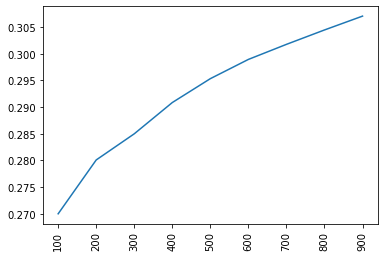

In [348]:
plt.plot(estim_list, score_list)
plt.xticks(rotation=90)

n_estimators는 100이 가장 적절하다.

In [349]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=2021)
model.fit(train[input_var], train['Rating'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1,
             random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

## 2.4 shap value 활용

shap value를 활용하면 인풋변수들 중 어떤게 타겟값에 큰 영향을 미치는 알 수 있다.

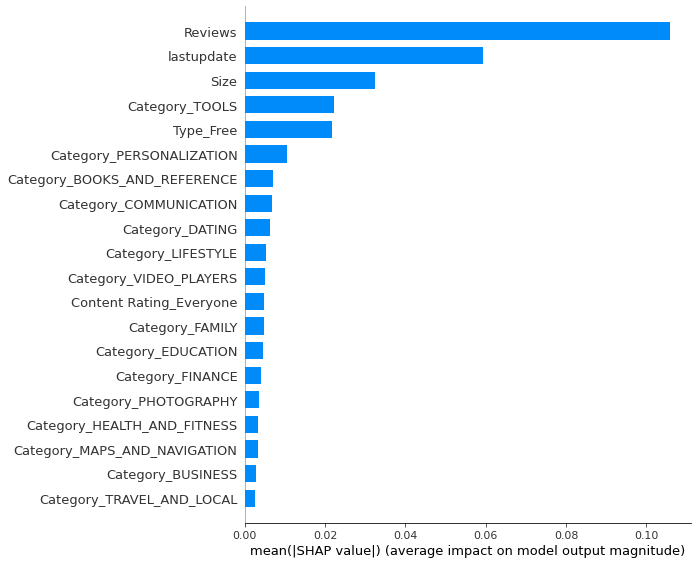

In [350]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train[input_var])
shap.summary_plot(shap_values, train[input_var], plot_type='bar')

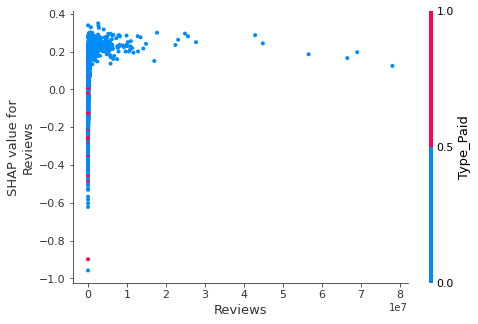

In [351]:
shap.dependence_plot('Reviews', shap_values, train[input_var])

- x값은 1000만 단위로 표시됐다.
- 리뷰 수가 약 100만 이상일 경우 안정적으로 점수에 긍정적인 영향을 주지만, 리뷰가 많을 수록 점수가 더 높아지는 것은 아니다.

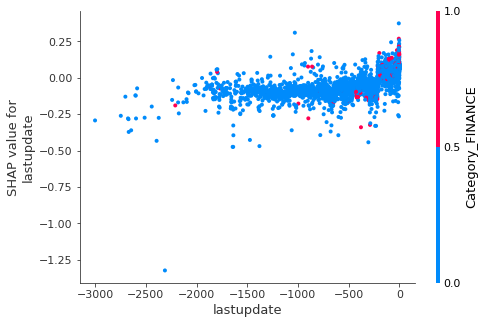

In [352]:
shap.dependence_plot('lastupdate', shap_values, train[input_var])

- x값이 0에 가까울 수록 최근에 업데이트 한 것이다.
- 약 200일 안에 업데이트를 했을 경우 점수에 긍정적인 영향이 더 크지만,
- 200일 이상이 되면 부정적인 영향이 많아진다.

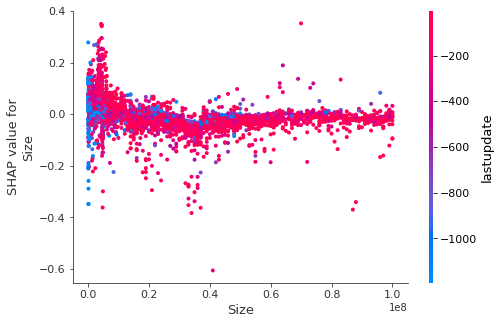

In [353]:
shap.dependence_plot('Size', shap_values, train[input_var])

- x값 0.1은 10M이다.
- EDA단계에서 앱용량이 클수록 점수에 긍정적인 영향을 준 것으로 확인됐지만, shap value를 통해 확인한 결과 반드시 그런것은 아니다.
- 용량이 15M이하일 때 더 높은 점수를 받으며, 그보다 클 때는 점수에 별다른 영향을 주지는 못한다.

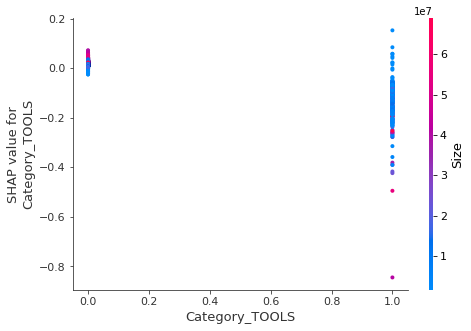

In [354]:
shap.dependence_plot('Category_TOOLS', shap_values, train[input_var])

- x값이 0이면 카테고리가 TOOLS 이외의 것들이고, 1이면 TOOLS이다.
- TOOLS 카테고리의 앱은 좋은 점수를 받지 못한다.

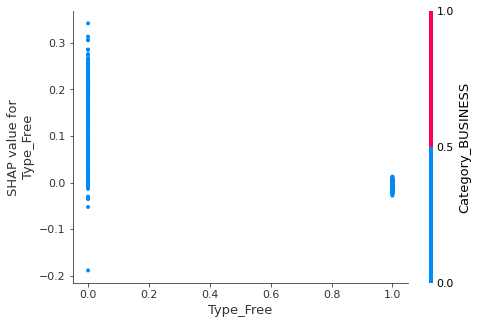

In [355]:
shap.dependence_plot('Type_Free', shap_values, train[input_var])

- x값이 0이면 무료가 아니고(유료), 1이면 무료다.
- 무료보다는 유료앱이 좋은 점수를 받는데 유리함을 알 수 있다. 

# 3. 분석 결과

### 3.1. EDA와 머신러닝을 종합적으로 분석하여 판단한 높은 점수를 받기 위한 조건들은 다음과 같다.

1. 100만개 이상의 리뷰
2. 카테고리가 HEALTH_AND_FITNESS, BOOKS_AND_REFERENCE, EVENTS 일 수록 유리
3. TOOLS와 DATING 카테고리는 피할 것
4. 15M 이하의 용량
5. 5000회 이상의 install
6. 유료(3달러 이하)
7. 이용등급이 Teen, Everyone 10+, Everyone
8. 적어도 200일 마다 업데이트

### 3.2. 분석 결과를 바탕으로 앱 개발시 고려해야할 사항으로는

- HEALTH_AND_FITNESS, BOOKS_AND_REFERENCE, EVENTS 카테고리에 부합하는 앱을 만든다.
- 앱의 용량이 너무 커지지 않도록 하도록 한다.
- 이용자가 리뷰를 남길 수 있도록 유도하는 시스템을 갖춘다.
- 3달러 이하의 유료 서비스로 출시한다.
- 이용등급은 Teen, Everyone 10+, Everyone에 부합하도록 만든다.

### 3.3. 이미 앱을 출시하여 서비스하고 있다면

- 현재보다 앱을 더 경량화 할 수 있도록 개선다.
- 이용자가 리뷰를 남길 수 있도록 유도하는 시스템을 갖춘다.
- 만약 이용등급이 Mature 17+, Adults only 18+ 라면 폭력성, 선정성 등을 낮춰 Teen, Everyone 10+, Everyone 등급으로 조정하는 방안을 고려해본다.
- 잦은 업데이트를 통해 앱의 성능을 지속적으로 개선한다.

# 4. 프로젝트 진행에서의 한계점

## 4.1. 중복된 데이터들

크롤링 과정에서 중복집계된 것으로 추측되는 데이터들이 있어 이를 제거해주는 과정이 필요했다. <br>
다행히 Teblue를 통해 해당 앱들을 찾아내고 제거 과정도 간단했지만, 우연히 앱 이름만 일치하고 실제로는 전혀 다른 앱들이 그 중에 있었을 가능성을 전혀 배제할 수는 없다.

## 4.2. '점수'에 대한 이상치 제거의 어려움

점수는 개인의 주관적인 경험과 판단에 의해 매겨지는 것으로, '점수가 너무 낮거나 높다고 해서 이를 이상치로 볼 수 있는가?'에 대한 딜레마가 있었다.<br>
고민 끝에 그러한 것들도 중요한 데이터라 판단해 제거하지 않기로 결정했다.

## 4.3. EDA와 Shap value 결과의 차이

Size에 대한 EDA의 결과와 Shap value로 본 결과가 정반대로 나와 해석에 어려움을 겪었다. <br>
그러나 데이터 분석의 결과가 완전히 선형적인 경우는 흔치 않기 때문에 복합적으로 판단할 수 있는 shap value의 결과를 따르기로 했다.